# 🎧 MelodyMind - Hybrid Music Recommendation System

Welcome to **MelodyMind**, a hybrid music recommendation system that blends **Content-Based Filtering** and **Collaborative Filtering** using **LightFM** for accurate and personalized recommendations.

---

## 🧠 What We'll Cover:
- **Setup & Imports**: Install and import required libraries.
- **Data Loading**: Load the music dataset.
- **Data Cleaning**: Clean and preprocess the dataset.
- **EDA**: Explore key statistics and visualizations.
- **Feature Engineering**: Prepare features for content-based filtering.
- **Content-Based Recommendation**: Recommend songs based on audio similarity.
- **Collaborative Filtering (LightFM)**: 
  - Prepare interaction matrix
  - Train and evaluate the model
- **Hybrid Logic**: Combine both methods for better results.
- **Model Saving**: Save the trained model and required data.
- **Deployment**: Explain how to deploy the system as a web app.

## 🧠 Key Concepts:
- **Content-Based Filtering**: Recommends songs similar in features.
- **Collaborative Filtering**: Learns from user-item interactions.
- **Hybrid System**: Merges both approaches for improved recommendations.

---

## 1. Setup and Import Libraries

We will start by installing and importing all necessary libraries required for this project.


In [15]:
!pip install --no-binary :all: lightfm

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, recall_at_k
from scipy.sparse import csr_matrix # To handle sparse matrix from LightFM if needed

warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_columns', None)

# For reproducibility
SEED = 42
np.random.seed(SEED)

print("Libraries imported successfully.")

Libraries imported successfully.


In [17]:
try:
    # Main dataset with audio features and basic metadata
    data = pd.read_csv(r'/kaggle/input/music-data-bro/data.csv')
    print("Dataset 'data.csv' loaded successfully.")
    # We will not load 'data_w_genres.csv' as it's likely not included.
    # Other files like 'data_by_artist.csv', 'data_by_genres.csv' exist
    # but contain aggregated data, not suitable for direct merging here.
except FileNotFoundError:
    print("Error: Make sure 'data.csv' is in the current directory.")
    print("Download from: https://www.kaggle.com/datasets/yamaerenay/spotify-dataset-19212020-160k-tracks")
    # Exit or raise error if file not found
    raise

Dataset 'data.csv' loaded successfully.


## 2. Data Cleaning

In [18]:
# Drop rows with essential missing values
# Check if 'id' column exists, if not, maybe use another unique identifier if available
essential_cols = ['id', 'name', 'artists', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'year', 'duration_ms', 'popularity']
# Verify these columns exist in your data.csv, adjust if necessary
available_cols = [col for col in essential_cols if col in data.columns]
missing_cols = [col for col in essential_cols if col not in data.columns]
if missing_cols:
    print(f"Warning: The following expected columns are missing and won't be used for cleaning: {missing_cols}")

data.dropna(subset=available_cols, inplace=True)

# Rename columns for clarity
data.rename(columns={'name': 'track_name', 'artists': 'artist_name'}, inplace=True)

In [19]:
# Convert artists string 'list' to actual list (handle potential errors)
# The format in data.csv is often like "['Artist 1', 'Artist 2']"
def parse_artists(artists_str):
    try:
        # Safely evaluate the string representation of a list
        import ast
        parsed_list = ast.literal_eval(artists_str)
        if isinstance(parsed_list, list):
            return parsed_list
        else:
            # Handle cases where it doesn't evaluate to a list but is a single string
             return [str(artists_str)]
    except (ValueError, SyntaxError):
         # Handle cases where it's just a plain string or malformed
        return [str(artists_str)]

data['artist_list'] = data['artist_name'].apply(parse_artists)
# Use first artist as primary for simplicity in grouping/user simulation later
data['primary_artist'] = data['artist_list'].apply(lambda x: x[0] if isinstance(x, list) and x else 'Unknown')

# Remove duplicates based on track name and primary artist (keeping first occurrence)
data.drop_duplicates(subset=['track_name', 'primary_artist'], keep='first', inplace=True)

# Ensure 'year' is integer if present
if 'year' in data.columns:
    data['year'] = data['year'].astype(int)

# Reset index after dropping rows
data.reset_index(drop=True, inplace=True)

print(f"Data shape after cleaning: {data.shape}")
print("Data cleaning finished (without external genre file).")
#print(data.head())
#print(data.info())

Data shape after cleaning: (155466, 21)
Data cleaning finished (without external genre file).


## 3. Exploratory Data Analysis (EDA)


--- Exploratory Data Analysis ---


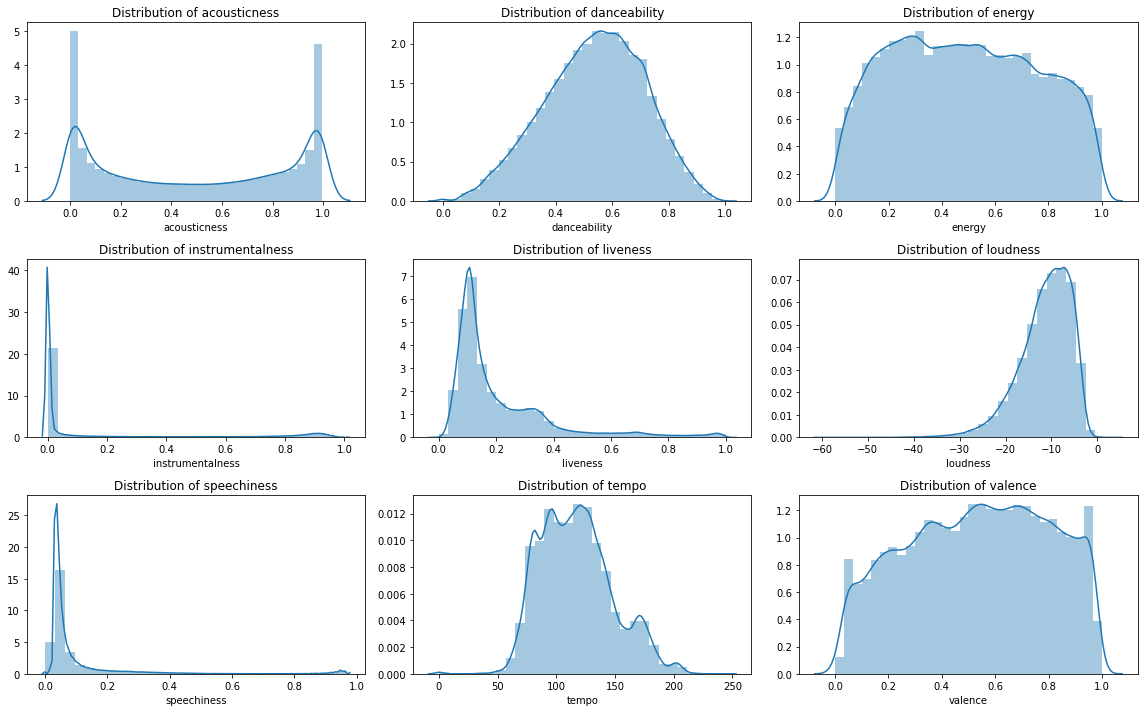

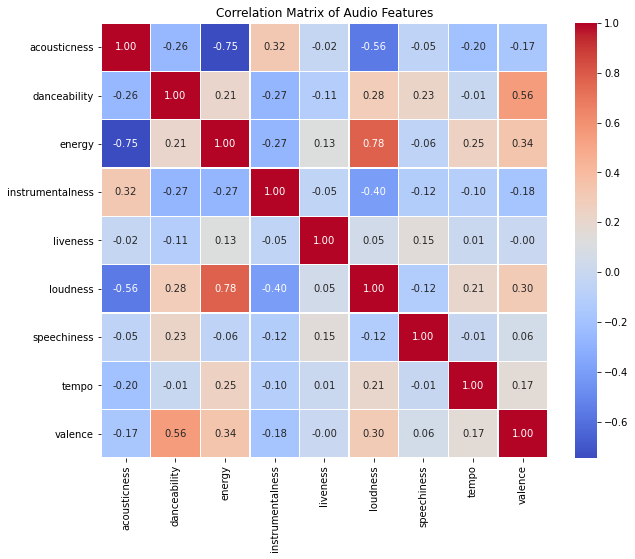

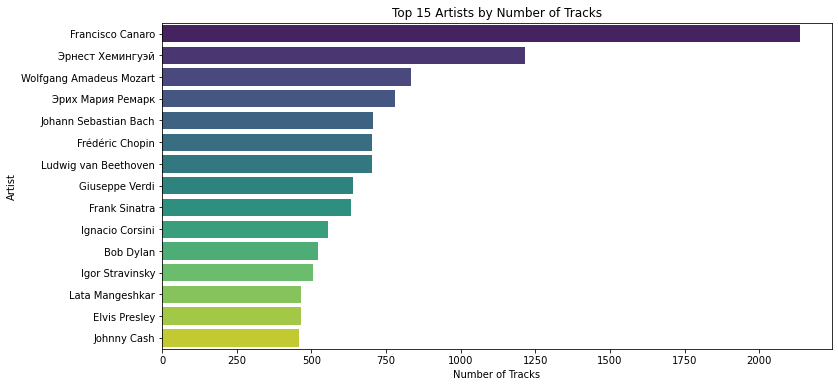

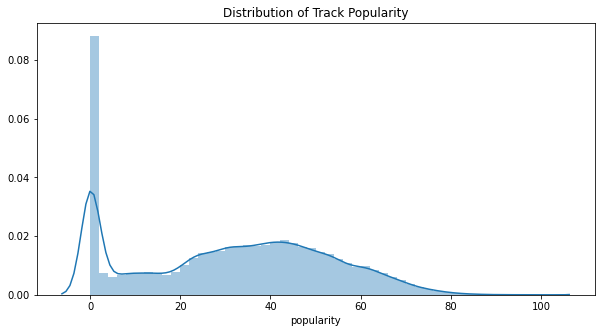

EDA Visualizations generated.


In [20]:
print("\n--- Exploratory Data Analysis ---")

import matplotlib.pyplot as plt
import seaborn as sns

# Use distplot instead of histplot for older seaborn versions
audio_features = [
    'acousticness', 'danceability', 'energy', 'instrumentalness',
    'liveness', 'loudness', 'speechiness', 'tempo', 'valence'
]

# Distribution of Key Audio Features
plt.figure(figsize=(16, 10))
for i, feature in enumerate(audio_features):
    plt.subplot(3, 3, i + 1)
    sns.distplot(data[feature], kde=True, bins=30, hist=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

# Correlation Heatmap of Audio Features
plt.figure(figsize=(10, 8))
correlation_matrix = data[audio_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Audio Features')
plt.show()

# Top Artists
top_n = 15
top_artists = data['primary_artist'].value_counts().head(top_n)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_artists.values, y=top_artists.index, palette='viridis')
plt.title(f'Top {top_n} Artists by Number of Tracks')
plt.xlabel('Number of Tracks')
plt.ylabel('Artist')
plt.show()

# Popularity Distribution
plt.figure(figsize=(10, 5))
sns.distplot(data['popularity'], kde=True, bins=50, hist=True)
plt.title('Distribution of Track Popularity')
plt.show()

print("EDA Visualizations generated.")

## 4. Feature Engineering & Preprocessing for Content-Based

In [21]:
print("\n--- Feature Engineering & Preprocessing ---")

# Select features for content-based filtering
content_features = ['acousticness', 'danceability', 'energy', 'instrumentalness',
                    'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'popularity']

# Scale numerical features to range [0, 1] for cosine similarity
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(data[content_features])

# Create a dataframe with scaled features for easier lookup
scaled_df = pd.DataFrame(scaled_features, columns=content_features, index=data.index)

print("Features scaled successfully.")
print(scaled_df.head())

# Create mapping from track ID to index and track name to index for easy lookup
track_id_to_idx = pd.Series(data.index, index=data['id']).to_dict()
track_name_to_idx = pd.Series(data.index, index=data['track_name']).to_dict() # Note: track names might not be unique! Handle this later.
idx_to_track_name = pd.Series(data['track_name'], index=data.index).to_dict()
idx_to_artist_name = pd.Series(data['primary_artist'], index=data.index).to_dict()

print("Index mappings created.")


--- Feature Engineering & Preprocessing ---
Features scaled successfully.
   acousticness  danceability  energy  instrumentalness  liveness  loudness  \
0      0.527108      0.607287   0.540           0.00305     0.100  0.754788   
1      0.228916      0.372470   0.480           0.70700     0.159  0.757889   
2      0.100201      0.275304   0.684           0.01450     0.946  0.787284   
3      0.185743      0.375506   0.545           0.58200     0.183  0.793751   
4      0.000699      0.318826   0.970           0.00000     0.277  0.865884   

   speechiness     tempo  valence  popularity  
0     0.033849  0.515783    0.547        0.26  
1     0.031579  0.615205    0.338        0.21  
2     0.052116  0.586171    0.279        0.41  
3     0.031682  0.615820    0.310        0.37  
4     0.105263  0.729515    0.423        0.48  
Index mappings created.


## 5. Content-Based Recommendation Logic

In [22]:
print("\n--- Content-Based Filtering ---")

# IMPORTANT CHANGE: We do NOT calculate the full cosine_sim_matrix here
# to avoid MemoryError. It will be calculated on-demand inside the function.
# print("Calculating cosine similarity matrix (this might take a while)...")
# cosine_sim_matrix = cosine_similarity(scaled_features) # <-- REMOVED THIS LINE

def get_content_recommendations(track_name, all_features, data_df, idx_to_track, idx_to_artist, num_recommendations=10):
    """
    Generates song recommendations based on content similarity, calculating
    similarity on-demand to conserve memory.

    Args:
        track_name (str): Name of the song to get recommendations for.
        all_features (np.ndarray): The full scaled feature matrix (N_songs, N_features).
        data_df (pd.DataFrame): The dataframe containing track information (for lookup).
        idx_to_track (dict): Mapping from index to track name.
        idx_to_artist (dict): Mapping from index to artist name.
        num_recommendations (int): Number of recommendations to return.

    Returns:
        list: List of recommended (track_name, artist_name) tuples.
              Returns empty list if track_name not found.
    """
    # Find all indices matching the track name (handle duplicates)
    matching_indices = data_df[data_df['track_name'] == track_name].index

    if not matching_indices.any():
        print(f"Warning: Track '{track_name}' not found in the dataset.")
        return []

    # Use the first match as the reference index
    idx = matching_indices[0]

    # Get the feature vector for the target track
    target_features = all_features[idx].reshape(1, -1) # Reshape to (1, n_features)

    # Calculate cosine similarity between the target track and ALL other tracks
    # This computes a (1, N_songs) array, which is memory efficient.
    sim_scores_vector = cosine_similarity(target_features, all_features)[0] # Get the single row of scores

    # Enumerate scores with indices: (index, score)
    sim_scores = list(enumerate(sim_scores_vector))

    # Sort songs based on similarity scores (descending)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get top N similar songs (excluding the song itself)
    # Start from 1 because index 0 is the song itself
    top_indices = [i[0] for i in sim_scores[1:num_recommendations + 1]]

    # Get track and artist names for recommended indices
    recommendations = [(idx_to_track.get(i, 'Unknown'), idx_to_artist.get(i, 'Unknown')) for i in top_indices]

    return recommendations

# --- Example Usage ---
# Make sure 'scaled_features' (the numpy array of scaled features) exists from Cell 14
# Make sure 'data', 'idx_to_track_name', 'idx_to_artist_name' exist from previous cells
example_song = "The Gloaming" # Make sure this exists in your data
if example_song in data['track_name'].values:
    print(f"\nContent-Based Recommendations for '{example_song}':")
    # Pass the full scaled_features array, data_df, and mappings
    recommendations = get_content_recommendations(example_song, scaled_features, data, idx_to_track_name, idx_to_artist_name, num_recommendations=5)
    if recommendations:
        for i, (track, artist) in enumerate(recommendations):
            print(f"{i+1}. {track} by {artist}")
    else:
        print("Could not generate recommendations.")
else:
    print(f"Example song '{example_song}' not found, skipping example.")


--- Content-Based Filtering ---

Content-Based Recommendations for 'The Gloaming':
1. Runaway by J. Cole
2. PartyIsntOver/Campfire/Bimmer (feat. Frank Ocean, feat. Laetitia Sadier, feat. Laetitia Sadier & Frank Ocean) by Tyler, The Creator
3. The Blacker The Berry by Kendrick Lamar
4. In the Cut by Wiz Khalifa
5. Watching Movies by Mac Miller


## 6. Collaborative Filtering (LightFM) - Data Preparation

In [23]:
print("\n--- Collaborative Filtering (LightFM) ---")
print("Preparing data for LightFM...")

# --- Simulate User Data ---
# The dataset lacks explicit user IDs and interactions. We simulate them.
# Strategy: Assign each primary artist as a 'user' and assume they 'liked' all their tracks.
# This is a simplification. For a real-world scenario, you'd use actual user listen/rating data.

# Create unique IDs for users (artists) and items (tracks)
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

data['user_id'] = user_encoder.fit_transform(data['primary_artist'])
data['item_id'] = item_encoder.fit_transform(data['id']) # Use the original unique track 'id'

num_users = data['user_id'].nunique()
num_items = data['item_id'].nunique()

print(f"Number of unique 'users' (artists): {num_users}")
print(f"Number of unique items (tracks): {num_items}")

# Create interaction data: (user_id, item_id, rating/interaction_weight)
# Using 1 for interaction weight (implicit feedback)
interactions_df = data[['user_id', 'item_id']].copy()
interactions_df['interaction'] = 1 # Implicit feedback: artist is associated with the track

print("Simulated interaction data created:")
print(interactions_df.head())

# --- Build LightFM Dataset ---
# Use LightFM's Dataset class to handle mappings and matrix building
dataset = Dataset()
dataset.fit(users=interactions_df['user_id'].unique(),
            items=interactions_df['item_id'].unique())

# Build the interactions matrix
(interactions_matrix, weights_matrix) = dataset.build_interactions(
    interactions_df[['user_id', 'item_id', 'interaction']].values
)

print("LightFM interaction matrix built:")
print(repr(interactions_matrix)) # Show sparse matrix representation

# Mappings from internal LightFM IDs back to our original IDs
# These are crucial for interpreting results
lightfm_mapping = dataset.mapping()
lightfm_user_id_map = lightfm_mapping[0]
lightfm_item_id_map = lightfm_mapping[2]

# Create reverse mappings (LightFM internal ID -> original ID)
# This requires iterating through the original mapping dictionaries
original_user_id_map = {v: k for k, v in lightfm_user_id_map.items()}
original_item_id_map = {v: k for k, v in lightfm_item_id_map.items()}

# Link original item ID back to track name and artist
item_id_to_details = pd.Series(
    list(zip(data['track_name'], data['primary_artist'])),
    index=data['item_id']
).to_dict()


--- Collaborative Filtering (LightFM) ---
Preparing data for LightFM...
Number of unique 'users' (artists): 19726
Number of unique items (tracks): 155466
Simulated interaction data created:
   user_id  item_id  interaction
0    10410    15681            1
1    18308    20201            1
2    18308    56577            1
3    18308   126961            1
4    16941    46005            1
LightFM interaction matrix built:
<19726x155466 sparse matrix of type '<class 'numpy.int32'>'
	with 155466 stored elements in COOrdinate format>


## 7. Collaborative Filtering (LightFM) - Model Training & Evaluation

In [24]:
print("\nTraining LightFM model...")

# Initialize the model
# WARP loss is suitable for implicit feedback
lightfm_model = LightFM(loss='warp',
                        random_state=SEED,
                        learning_rate=0.03,
                        no_components=30) # Number of latent factors

# Train the model
# Use weights_matrix as sample_weight if you have varying interaction strengths
lightfm_model.fit(interactions_matrix,
                  epochs=10,         # Adjust epochs as needed
                  num_threads=4)     # Use multiple cores if available

print("LightFM model training complete.")


Training LightFM model...
LightFM model training complete.


In [25]:
# --- Evaluate the Model ---
# Note: Evaluation on the full training set can be optimistic.
# A proper train/test split of interactions is better for robust evaluation.
print("\nEvaluating LightFM model (on training data)...")

# Use precision@k and recall@k
# k=10 means we look at the top 10 recommendations
precision = precision_at_k(lightfm_model, interactions_matrix, k=10).mean()
recall = recall_at_k(lightfm_model, interactions_matrix, k=10).mean()

print(f"Precision@10: {precision:.4f}")
print(f"Recall@10: {recall:.4f}")


Evaluating LightFM model (on training data)...
Precision@10: 0.1423
Recall@10: 0.1719


## 8. Hybrid Recommendation Logic

In [26]:
print("\n--- Hybrid Recommendation System ---")

def get_lightfm_recommendations(user_id, model, num_recommendations=10):
    """
    Generates recommendations for a given user_id using a trained LightFM model.
    """
    # Using the globally available LightFM mappings and item details
    if user_id not in lightfm_user_id_map:
        print(f"Warning: User ID {user_id} not found in LightFM mapping.")
        return []

    internal_user_id = lightfm_user_id_map[user_id]
    # num_items is available globally from Cell 18
    all_item_indices = np.arange(num_items)  # Internal LightFM item indices

    # Predict scores for all items for the given user
    scores = model.predict(internal_user_id, all_item_indices)

    # Get top N item indices based on scores
    top_internal_item_indices = np.argsort(-scores)[:num_recommendations]

    # Map internal item indices back to original item IDs
    recommended_item_ids = [original_item_id_map[i] for i in top_internal_item_indices]

    # Get track details for the recommended item IDs
    # item_id_to_details is available globally from Cell 18
    recommendations = [item_id_to_details[item_id] for item_id in recommended_item_ids if item_id in item_id_to_details]

    return recommendations


def hybrid_recommendation(user_id, reference_track_name, num_recommendations=10):
    """
    Generates hybrid recommendations combining content-based and collaborative filtering.

    Args:
        user_id (int): The user ID (original, from our encoding) to get recommendations for.
        reference_track_name (str): A track name to anchor content-based results.
        num_recommendations (int): Total number of recommendations desired.

    Returns:
        list: List of unique recommended (track_name, artist_name) tuples.
    """
    print(f"\nGenerating hybrid recommendations for User ID: {user_id}, based on track: '{reference_track_name}'")

    # ✅ Updated call: Pass scaled_features, data_df, and mappings
    # Assuming scaled_features, data, idx_to_track_name, idx_to_artist_name are available from previous cells
    content_recs = get_content_recommendations(reference_track_name, scaled_features, data, idx_to_track_name, idx_to_artist_name, num_recommendations=num_recommendations * 2)

    # Collaborative Filtering recommendations using LightFM
    # lightfm_model is available globally
    collab_recs = get_lightfm_recommendations(user_id, lightfm_model, num_recommendations=num_recommendations * 2)

    # Combine and deduplicate
    combined_recs = {}

    # Add collaborative recommendations first (more personalized)
    for track, artist in collab_recs:
        if (track, artist) not in combined_recs:
            combined_recs[(track, artist)] = "collab"

    # Add content-based recommendations
    for track, artist in content_recs:
        if (track, artist) not in combined_recs:
            combined_recs[(track, artist)] = "content"

    # Final list
    final_recommendations = list(combined_recs.keys())

    return final_recommendations[:num_recommendations]


# --- Example Usage ---
# Pick a user ID (ensure it's in your user_id list)
# Assuming data DataFrame and user_id column exist from previous cells
example_user_id = data['user_id'].iloc[500]  # Just picking an arbitrary user ID
example_user_artist = data[data['user_id'] == example_user_id]['primary_artist'].iloc[0]

# Pick a reference track (ensure it exists in your dataset)
example_ref_track = "Come As You Are" # Make sure this track exists in your data

print(f"\nHybrid Recommendation Example for User: {example_user_artist} (ID: {example_user_id})\n")
# Assuming scaled_features, data, idx_to_track_name, idx_to_artist_name, and lightfm_model are available globally
hybrid_recs = hybrid_recommendation(user_id=example_user_id,
                                    reference_track_name=example_ref_track,
                                    num_recommendations=10)

if hybrid_recs:
    print("Top Hybrid Recommendations:")
    for i, (track, artist) in enumerate(hybrid_recs):
        print(f"{i+1}. {track} by {artist}")
else:
    print("Could not generate hybrid recommendations (maybe user/track not found?).")


--- Hybrid Recommendation System ---

Hybrid Recommendation Example for User: Bee Gees (ID: 1597)


Generating hybrid recommendations for User ID: 1597, based on track: 'Come As You Are'
Top Hybrid Recommendations:
1. How Can You Mend A Broken Heart by Bee Gees
2. Massachussetts by Bee Gees
3. How Deep Is Your Love - Supreme Beings Of Leisure Remix by Bee Gees
4. Words by Bee Gees
5. Reaching Out by Bee Gees
6. You Stepped Into My Life by Bee Gees
7. Search, Find by Bee Gees
8. Please Read Me by Bee Gees
9. Rest Your Love On Me by Bee Gees
10. Melody Fair by Bee Gees


## 9. Save Model Components

In [29]:
print("\n--- Saving Model Components ---")

import pickle

# Ensure scaled_features and scaler are available from Cell 14
# The scaled_features computed in Cell 14 is the correct one to save.

# --- ADD THIS DEBUG PRINT STATEMENT ---
print(f"Debug: Type of scaled_features before saving: {type(scaled_features)}")
if isinstance(scaled_features, np.ndarray):
    print(f"Debug: Shape of scaled_features before saving: {scaled_features.shape}")
else:
    print("Debug: scaled_features is not a NumPy array (might be None or something else).")
# --- END DEBUG PRINT STATEMENT ---


# Step 1: Define what to save (use the scaled_features and scaler from Cell 14)
save_path = "/kaggle/working/hybrid_music_recommender_components.pkl"

# Re-define content_features as used in Cell 14 for saving the relevant columns in data_lookup
content_features_list = ['acousticness', 'danceability', 'energy', 'instrumentalness',
                         'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'popularity']


components = {
    'lightfm_model': lightfm_model,
    'scaler': scaler, # Save the scaler fitted in Cell 14 (on 10 features)
    'scaled_features': scaled_features, # Save the scaled_features array from Cell 14 (derived from 10 features)
    # Saved data should include original index to align with scaled_features
    # Include the 10 content features and year in saved data for potential future use/inspection
    'data': data[['id', 'track_name', 'primary_artist', 'user_id', 'item_id', 'year'] + content_features_list].copy(), # Use .copy() to avoid potential SettingWithCopyWarning later
    'user_encoder': user_encoder,
    'item_encoder': item_encoder, # item_encoder is not strictly needed if item_id_to_details is saved, but harmless
    'lightfm_user_id_map': lightfm_user_id_map,
    'lightfm_item_id_map': lightfm_item_id_map,
    'original_user_id_map': original_user_id_map,
    'original_item_id_map': original_item_id_map,
    'item_id_to_details': item_id_to_details,
    # Save index mappings that align with the scaled_features and data_lookup index
    'idx_to_track_name': idx_to_track_name,
    'idx_to_artist_name': idx_to_artist_name
}

# Step 2: Save using pickle
try:
    with open(save_path, 'wb') as f:
        pickle.dump(components, f)
    print(f"✅ All components saved successfully to: {save_path}")
except Exception as e:
    print(f"❌ Error saving components: {e}")

# Optional Step 3: Load and test
try:
    with open(save_path, 'rb') as f:
        loaded_components = pickle.load(f)
    print("✅ Components loaded successfully (test passed).")
    # Optional: Verify some loaded components
    print(f"Loaded scaled_features shape: {loaded_components['scaled_features'].shape}")
    print(f"Loaded data shape: {loaded_components['data'].shape}")
except Exception as e:
    print(f"❌ Error loading saved components: {e}")


--- Saving Model Components ---
Debug: Type of scaled_features before saving: <class 'numpy.ndarray'>
Debug: Shape of scaled_features before saving: (155466, 10)
✅ All components saved successfully to: /kaggle/working/hybrid_music_recommender_components.pkl
✅ Components loaded successfully (test passed).
Loaded scaled_features shape: (155466, 10)
Loaded data shape: (155466, 16)


## 10. Deployment Simulation (Streamlit Example Structure)